In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
model_path='sensor_selectiooon.h5'

## import odpowiednio przerobionego pliku

In [51]:
# DANE po MOVING AVERAGE

df_train = pd.read_csv("train_moving_avg.csv", sep=' ', header = None)
df_test = pd.read_csv("test_moving_avg.csv", sep=' ', header=None)
df_truth = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)

column_names_train = ['label','id','s11','s12','s13','s14','s15','s17','s2','s20','s21','s3','s4','s7','s8','s9','RUL','cycle']

column_names_test = ['label','id','s11','s12','s13','s14','s15','s17','s2','s20','s21','s3','s4','s7','s8','s9','cycle']
df_test.columns=column_names_test
df_train.columns=column_names_train


In [34]:
# DANE bez moving average
df_train = pd.read_csv("train_sensor_selected.csv", sep=' ', header = None)
df_test = pd.read_csv("test_sensor_selected.csv", sep=' ', header=None)
df_truth = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)

column_names_train = ['id','cycle', 's2', 's3', 's4', 's7', 's8', 's9','s11', 's12', 's13', 's14', 's15',
                      's17', 's20', 's21','RUL','label' ]

column_names_test = ['id','cycle', 's2', 's3', 's4',  's7', 's8', 's9','s11', 's12', 's13', 's14', 's15',
                      's17', 's20', 's21','label' ]
df_test.columns=column_names_test
df_train.columns=column_names_train

In [152]:
#Dane po SG FILTER
df_train = pd.read_csv("train_SG_filter.csv", sep=' ', header = None)
df_test = pd.read_csv("test_SG_filter.csv", sep=' ', header=None)
df_truth = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)

column_names_train = ['s11','s12','s13','s14','s15','s17','s2','s20','s21','s3','s4','s7','s8','s9','cycle','id','RUL','label']

column_names_test = ['s11','s12','s13','s14','s15','s17','s2','s20','s21','s3','s4','s7','s8','s9','cycle','id','label']
df_test.columns=column_names_test
df_train.columns=column_names_train


## Dodawanie kolumn RUL, skalowanie danych

In [153]:

df_truth.drop(df_truth[[1]], axis=1, inplace = True)
rul = pd.DataFrame(df_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
df_truth.columns = ['more']
df_truth['id'] = df_truth.index + 1
df_truth['max'] = rul['max'] + df_truth['more']
df_truth.drop('more', axis=1, inplace=True)

df_test = df_test.merge(df_truth, on=['id'], how='left')
df_test['RUL'] = df_test['max'] - df_test['cycle']
df_test.drop('max', axis=1, inplace=True)

df_test['rul_norm']=df_test['RUL']
df_train['rul_norm']=df_train['RUL']

In [154]:

df_test_red = df_test[df_test.columns.difference(['id','cycle','RUL'])]
df_train_red = df_train[df_train.columns.difference(['id','cycle','RUL',])]

min_max_scaler_test= preprocessing.MinMaxScaler()
min_max_scaler_test.fit(df_test_red)

min_max_scaler_train=preprocessing.MinMaxScaler()
min_max_scaler_train.fit(df_train_red)

df_test_norm = pd.DataFrame(min_max_scaler_test.transform(df_test_red), 
                            columns=df_test_red.columns, 
                            index=df_test_red.index)


df_train_norm = pd.DataFrame(min_max_scaler_train.transform(df_train_red), 
                            columns=df_train_red.columns, 
                            index=df_train_red.index)

df_train_norm=df_train[['id','cycle','RUL']].join(df_train_norm)
df_test_norm = df_test[['id','cycle','RUL']].join(df_test_norm)

## Przygotowanie sekwencji do użycia w LSTM

In [155]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

## Długość sekwencji musi być zredukowana do 20, gdyż najkrótszy wektor zbioru testowego ma długość 20

In [184]:
sequence_length = 20
print('Długość sekwencji:  ', sequence_length)

Długość sekwencji:   20


In [157]:
# Wybieram które kolumny będą użyte do sekwencji
sequence_cols = df_test_norm.columns.difference(['id','cycle','RUL'])

seq_gen = (list(gen_sequence(df_train_norm[df_train_norm['id']==id], sequence_length, sequence_cols)) 
           for id in df_train_norm['id'].unique())

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print('SEQUENCE ARRAY SHAPE:  ',seq_array.shape)


SEQUENCE ARRAY SHAPE:   (48559, 20, 16)


In [158]:
sequence_cols

Index(['label', 'rul_norm', 's11', 's12', 's13', 's14', 's15', 's17', 's2',
       's20', 's21', 's3', 's4', 's7', 's8', 's9'],
      dtype='object')

In [159]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]


In [160]:
label_gen = [gen_labels(df_train_norm[df_train_norm['id']==id], sequence_length, ['RUL']) 
             for id in df_train_norm['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
print('LABEL ARRAY SHAPE:   ',label_array.shape)

LABEL ARRAY SHAPE:    (48559, 1)


## Budowanie sieci neuronwej, dobór parametrów


In [161]:
import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [162]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         activation='relu',
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

# model.add(LSTM(
#           units=40,
#           activation='relu',
#           return_sequences=True))
# model.add(Dropout(0.3))

# model.add(LSTM(
#           units=50,
#           activation='sigmoid',
#           return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=nb_out))
model.add(Activation("relu"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

In [163]:
history = model.fit(seq_array, label_array, epochs=120, batch_size=400, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

print(history.history.keys())

Train on 43703 samples, validate on 4856 samples
Epoch 1/120
43703/43703 [==============================] - 53s 1ms/step - loss: 11701.5471 - mean_absolute_error: 88.1824 - r2_keras: -1.9138 - val_loss: 13723.2294 - val_mean_absolute_error: 94.2210 - val_r2_keras: -2.0194
Epoch 2/120
43703/43703 [==============================] - 50s 1ms/step - loss: 10753.9045 - mean_absolute_error: 83.4059 - r2_keras: -1.6765 - val_loss: 12751.4387 - val_mean_absolute_error: 89.7643 - val_r2_keras: -1.7883
Epoch 3/120
43703/43703 [==============================] - 47s 1ms/step - loss: 9926.5736 - mean_absolute_error: 79.2718 - r2_keras: -1.4697 - val_loss: 11878.0439 - val_mean_absolute_error: 85.7885 - val_r2_keras: -1.5834
Epoch 4/120
43703/43703 [==============================] - 47s 1ms/step - loss: 9167.6857 - mean_absolute_error: 75.4793 - r2_keras: -1.2809 - val_loss: 11055.0749 - val_mean_absolute_error: 82.0735 - val_r2_keras: -1.3933
Epoch 5/120
43703/43703 [==============================] 

Epoch 38/120
43703/43703 [==============================] - 49s 1ms/step - loss: 320.4449 - mean_absolute_error: 10.8583 - r2_keras: 0.9208 - val_loss: 385.3472 - val_mean_absolute_error: 11.9304 - val_r2_keras: 0.9310
Epoch 39/120
43703/43703 [==============================] - 60s 1ms/step - loss: 292.0789 - mean_absolute_error: 10.3458 - r2_keras: 0.9279 - val_loss: 391.6163 - val_mean_absolute_error: 14.0521 - val_r2_keras: 0.9246
Epoch 40/120
43703/43703 [==============================] - 57s 1ms/step - loss: 279.6238 - mean_absolute_error: 10.2915 - r2_keras: 0.9309 - val_loss: 439.7346 - val_mean_absolute_error: 16.2384 - val_r2_keras: 0.9118
Epoch 41/120
43703/43703 [==============================] - 50s 1ms/step - loss: 257.2931 - mean_absolute_error: 9.9321 - r2_keras: 0.9365 - val_loss: 266.9506 - val_mean_absolute_error: 9.6189 - val_r2_keras: 0.9559
Epoch 42/120
43703/43703 [==============================] - 52s 1ms/step - loss: 241.0729 - mean_absolute_error: 9.7606 - r2_k

Epoch 76/120
43703/43703 [==============================] - 47s 1ms/step - loss: 103.5704 - mean_absolute_error: 7.1215 - r2_keras: 0.9743 - val_loss: 35.9178 - val_mean_absolute_error: 4.4862 - val_r2_keras: 0.9924
Epoch 77/120
43703/43703 [==============================] - 47s 1ms/step - loss: 99.0178 - mean_absolute_error: 6.9163 - r2_keras: 0.9755 - val_loss: 42.2579 - val_mean_absolute_error: 5.4105 - val_r2_keras: 0.9908
Epoch 78/120
43703/43703 [==============================] - 47s 1ms/step - loss: 99.0616 - mean_absolute_error: 6.9151 - r2_keras: 0.9754 - val_loss: 24.3003 - val_mean_absolute_error: 3.5579 - val_r2_keras: 0.9944
Epoch 79/120
43703/43703 [==============================] - 47s 1ms/step - loss: 100.4530 - mean_absolute_error: 6.9900 - r2_keras: 0.9750 - val_loss: 14.5055 - val_mean_absolute_error: 1.8272 - val_r2_keras: 0.9977
Epoch 80/120
43703/43703 [==============================] - 47s 1ms/step - loss: 100.2962 - mean_absolute_error: 6.9528 - r2_keras: 0.9751

In [164]:
def model_wykresy(history2, name):
    fig_loss = plt.figure(figsize=(10, 10))
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Funckja kosztu w zależności od liczby epok')
    plt.ylabel('Funkcja kosztu')
    plt.xlabel('Epoki')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    fig_loss.savefig("model_regression_loss" + str(name)+".png")
    print("Saved as: model_regression_loss" + str(name)+".png") 
    
    fig_mae = plt.figure(figsize=(10, 10))
    plt.plot(history2.history['mean_absolute_error'])
    plt.plot(history2.history['val_mean_absolute_error'])
    plt.title('Błąd średniokwadratowy MAE w zależności od liczby epok')
    plt.ylabel('MAE')
    plt.xlabel('Epoki')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_mae.savefig("model_mae" + str(name)+".png")
    print("Saved as: model_mae" + str(name)+".png")
    
    fig_r2 = plt.figure(figsize=(10,10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('Model r^2')
    plt.ylabel('R^2')
    plt.xlabel('Epoki')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_r2.savefig("model_r2" + str(name)+".png")
    print("Saved as: model_r2" + str(name)+".png")
    

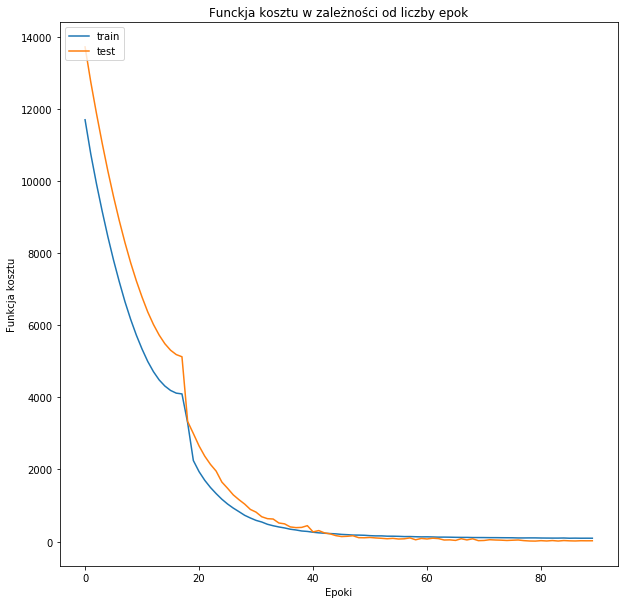

Saved as: model_regression_loss_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20.png


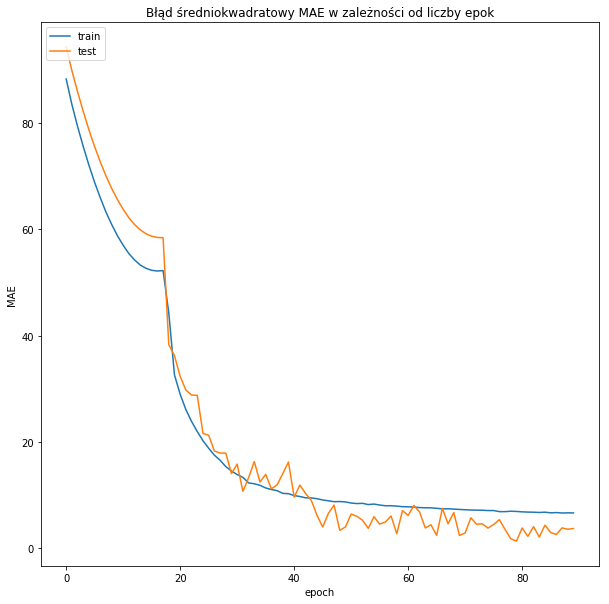

Saved as: model_mae_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20.png


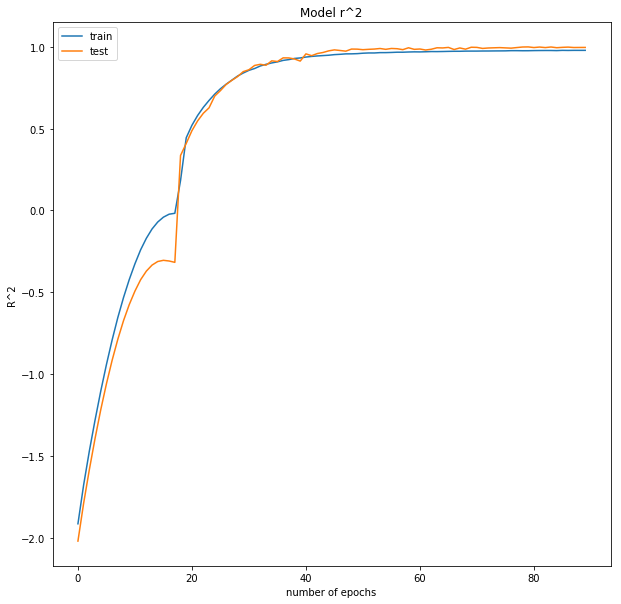

Saved as: model_r2_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20.png


In [165]:
model_wykresy(history, '_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20')

In [166]:
def metrics_train(model,name):
    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred)
    test_set.to_csv('submit_train'+str(name)+'.csv', index = None)

In [182]:
def metrics_test(df_test_label_normalized, sequence_cols,sequence_length,model_path,name):
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [df_test_label_normalized[df_test_label_normalized['id']==id][sequence_cols].values[-sequence_length:] 
                           for id in df_test_label_normalized['id'].unique() if len(df_test_label_normalized[df_test_label_normalized['id']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
    print(seq_array_test_last.shape)

    y_mask = [len(df_test_label_normalized[df_test_label_normalized['id']==id]) >= sequence_length for id in df_test_label_normalized['id'].unique()]
    label_array_test_last = df_test_label_normalized.groupby('id')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    print(label_array_test_last.shape)

    if os.path.isfile(model_path):
        estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

        scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
        print('\nMAE: {}'.format(scores_test[1]))
        print('\nR^2: {}'.format(scores_test[2]))

        y_pred_test = estimator.predict(seq_array_test_last)
        y_true_test = label_array_test_last

        test_set = pd.DataFrame(y_pred_test)
        test_set.to_csv('submit_test_'+str(name)+'.csv', index = None)

        fig_verify = plt.figure(figsize=(25, 5))
    
        plt.plot(y_pred_test, color="blue", alpha=0.9)
        plt.plot(y_true_test, color="palegreen", alpha=0.9, linewidth=3)
        plt.title('Sprawdzenie predykcji')
        plt.ylabel('Przewidywana liczba cykli')
        plt.xlabel('Numer silnika')
        plt.legend(['Predykcja', 'Prawdziwe dane '], loc='upper left')
        plt.show()
        fig_verify.savefig("model_regression_verify_"+str(name)+".png")
        table=[]
        
    
        for i in range(len(y_pred_test)):
            if int(math.ceil(y_pred_test[i]))==y_true_test[i]:
                table.append('rowne')
            if int(math.ceil(y_pred_test[i]))>y_true_test[i]:
                table.append('pred')
            if int(math.ceil(y_pred_test[i]))<y_true_test[i]:
                table.append('true')
        print("dokladnie trafione:   ", table.count('rowne'))
        print("pred wieksze:   ", table.count('pred'))
        print("true wieksze:   ", table.count('true'))
            

In [168]:
metrics_train(model, '_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20')

48559/48559 [==============================] - 18s 370us/step

MAE: 3.4227406866858443

R^2: 0.994366289050485
48559/48559 [==============================] - 24s 496us/step


(259, 20, 16)
(259, 1)

MAE: 5.77058338290476

R^2: 0.9856652026010756


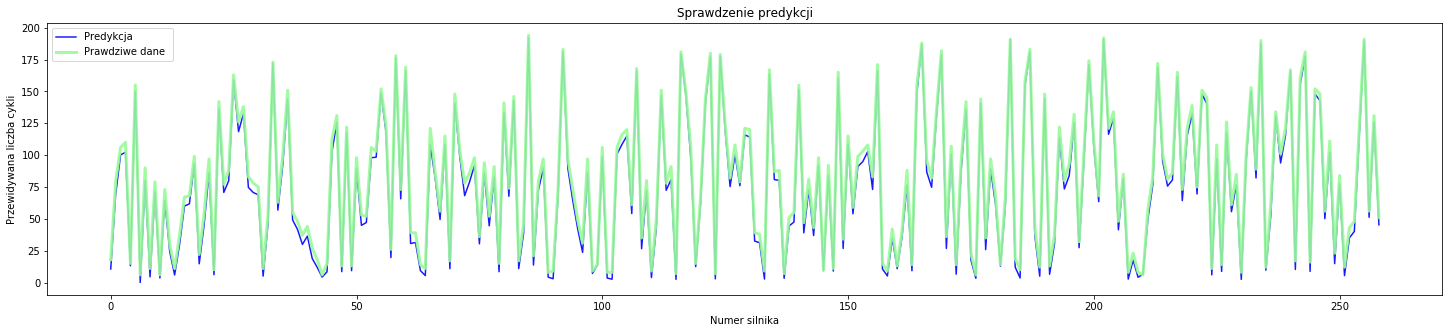

dokladnie trafione:    5
pred wieksze:    1
true wieksze:    253


In [183]:
metrics_test(df_test_norm, sequence_cols,sequence_length,
                          model_path,'_LSTM_sg2_100_50_relu_relu_rmsprop_seq_20')